In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

import random
import imp
import sys

from IPython.html.widgets import *


#my libraries
%matplotlib inline

sys.path.append('/home/tony/code/python/notebooks/MyLib/RL_agents')

import cat_mouse_game
imp.reload(cat_mouse_game)
from cat_mouse_game import cat_mouse_game

import pick_strategy
imp.reload(pick_strategy)
from pick_strategy import pick_strategy

import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)


# For animated plots
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

from matplotlib import animation

def animation_example():
    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure()
    ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
    line, = ax.plot([], [], lw=2)

    # initialization function: plot the background of each frame
    def init():
        line.set_data([], [])
        return line,

    # animation function.  This is called sequentially
    def animate(i):
        x = np.linspace(0, 2, 1000)
        y = np.sin(2 * np.pi * (x - 0.01 * i))
        line.set_data(x, y)
        return line,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=100, interval=20, blit=True)

    # call our new function to display the animation
    display_animation(anim)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
num_holes = 5

#cats
moving_cat = pick_strategy.sequence_agent(num_holes, [[0], [1], [2], [3], [4]], [500, 500, 500, 500, 500], 'moving_cat')
one_hole_cat = pick_strategy.random_subset_agent(num_holes, [0, 1], 'one_hole_cat')
saw_distribution_cat = pick_strategy.distribution_agent(num_holes, range(num_holes), 'saw_cat')

#mice
eta_greedy_RL_mouse = pick_strategy.eta_greedy_RL_agent(num_holes,  'eta_mouse Q1 eta=0.1 step=0.01', init_Q=1.0, eta=0.1, step_size=0.01)
eta_greedy_RL_mouse2 = pick_strategy.eta_greedy_RL_agent(num_holes, 'eta_mouse Q1 eta=0.1 step=0.05', init_Q=1.0, eta=0.1, step_size=0.05)
eta_greedy_RL_mouse3 = pick_strategy.eta_greedy_RL_agent(num_holes, 'eta_mouse Q1 eta=0.1 step=0.20', init_Q=1.0, eta=0.1, step_size=0.1)


softmax_RL_mouse = pick_strategy.softmax_RL_agent(num_holes, 'softmax_mouse Q1 t=0.01', init_Q=1.0, temp=0.01, step_size=0.1)
softmax_RL_mouse2 = pick_strategy.softmax_RL_agent(num_holes, 'softmax_mouse Q1 t=0.1', init_Q=1.0, temp=0.1, step_size=0.1)
softmax_RL_mouse3 = pick_strategy.softmax_RL_agent(num_holes, 'softmax_mouse Q1 t=1.0', init_Q=1.0, temp=1.0, step_size=0.1)

In [3]:
def run_game(mice, cats, num_holes, total_rounds, iters_per_round, summary_last_n=50):
    game = cat_mouse_game(cats, mice, num_holes)
    #game.reset_game()

    for cat in cats:
        cat.reset()
    for mouse in mice:
        mouse.reset()
    
    mouse_dists = []
    cat_dists = []
    for k in range(1, total_rounds+1):
        game.run_n_rounds(iters_per_round)

        ##for the whole game
        #mouse_dist = mice[0].get_str_hole_distribution()
        #cat_dist = cats[0].get_str_hole_distribution()

        #for the last N rounds
        mouse_dists_for_round = {}
        for mouse in mice:
            print(mouse.summary())
            mouse_dist = mouse.get_last_n_dist(summary_last_n)
            mouse_dists_for_round[mouse.name] = mouse_dist
        mouse_dists.append(mouse_dists_for_round)
            
        cat_dists_for_round = {}
        for cat in cats:
            print(cat.summary())
            cat_dist = cat.get_last_n_dist(summary_last_n)
            cat_dists_for_round[cat.name] = cat_dist
        cat_dists.append(cat_dists_for_round)
        
    return pd.DataFrame(mouse_dists), pd.DataFrame(cat_dists)


def cat_mouse_dists(cat_dists, mouse_dists, round):
    print "ROUND #{0}".format(round)
    
    num_rows = max(cat_dists.values.shape[1], mouse_dists.values.shape[1])
    idx = 1
    plt.figure(figsize=(16, 18))
    
    for mouse_name in mouse_dists.columns.values:
        plt.subplot(num_rows, 2, idx)
        idx += 1
        
        dist = mouse_dists[mouse_name][round]
        dist = np.array(dist)/float(np.sum(dist))

        D = [('hole {0:02d}'.format(i), val) for i, val in enumerate(dist)]
        labels, values = zip(*D)
        plt.bar(range(len(D)), values, align='center')
        plt.xticks(range(len(D)), labels)
        plt.ylim((0, sum(dist)))
        plt.title('mouse: {0}'.format(mouse_name))
    
    for cat_name in cat_dists.columns.values:
        plt.subplot(num_rows, 2, idx)
        idx += 1
        
        dist = cat_dists[cat_name][round]
        dist = np.array(dist)/float(np.sum(dist))

        D = [('hole {0:02d}'.format(i), val) for i, val in enumerate(dist)]
        labels, values = zip(*D)
        plt.bar(range(len(D)), values, align='center', color='red')
        plt.xticks(range(len(D)), labels)
        plt.ylim((0, sum(dist)))
        plt.title('cat: {0}'.format(cat_name))
    
    
def get_cat_mouse_dists_interact_func(cat_dists, mouse_dists):
    return lambda round: cat_mouse_dists(cat_dists, mouse_dists, round)

# Moving uniform distribution cat

In [4]:
mouse_dists, cat_dists = run_game(mice=[softmax_RL_mouse, softmax_RL_mouse2, softmax_RL_mouse3,
                                        eta_greedy_RL_mouse, eta_greedy_RL_mouse2, eta_greedy_RL_mouse3], 
                                  cats=[moving_cat], 
                                  num_holes=5,
                                  total_rounds=200, iters_per_round=20, summary_last_n=50)

00020: agent: softmax_mouse Q1 t=0.01	score: 0.95/0.95	dist:[1, 1, 7, 6, 5]
00020: agent: softmax_mouse Q1 t=0.1	score: 0.95/0.95	dist:[1, 3, 6, 4, 6]
00020: agent: softmax_mouse Q1 t=1.0	score: 0.85/0.85	dist:[3, 5, 4, 6, 2]
00020: agent: eta_mouse Q1 eta=0.1 step=0.01	score: 1.00/1.00	dist:[0, 8, 3, 3, 6]
00020: agent: eta_mouse Q1 eta=0.1 step=0.05	score: 0.95/0.95	dist:[1, 8, 7, 2, 2]
00020: agent: eta_mouse Q1 eta=0.1 step=0.20	score: 0.90/0.90	dist:[2, 4, 7, 5, 2]
00020: agent: moving_cat	score: 0.40/0.40	dist:[20, 0, 0, 0, 0]
00040: agent: softmax_mouse Q1 t=0.01	score: 0.97/0.97	dist:[1, 2, 10, 15, 12]
00040: agent: softmax_mouse Q1 t=0.1	score: 0.97/0.97	dist:[1, 11, 10, 6, 12]
00040: agent: softmax_mouse Q1 t=1.0	score: 0.82/0.82	dist:[7, 8, 10, 9, 6]
00040: agent: eta_mouse Q1 eta=0.1 step=0.01	score: 0.93/0.93	dist:[3, 11, 7, 12, 7]
00040: agent: eta_mouse Q1 eta=0.1 step=0.05	score: 0.95/0.95	dist:[2, 13, 13, 6, 6]
00040: agent: eta_mouse Q1 eta=0.1 step=0.20	score: 0.93/0

ROUND #0


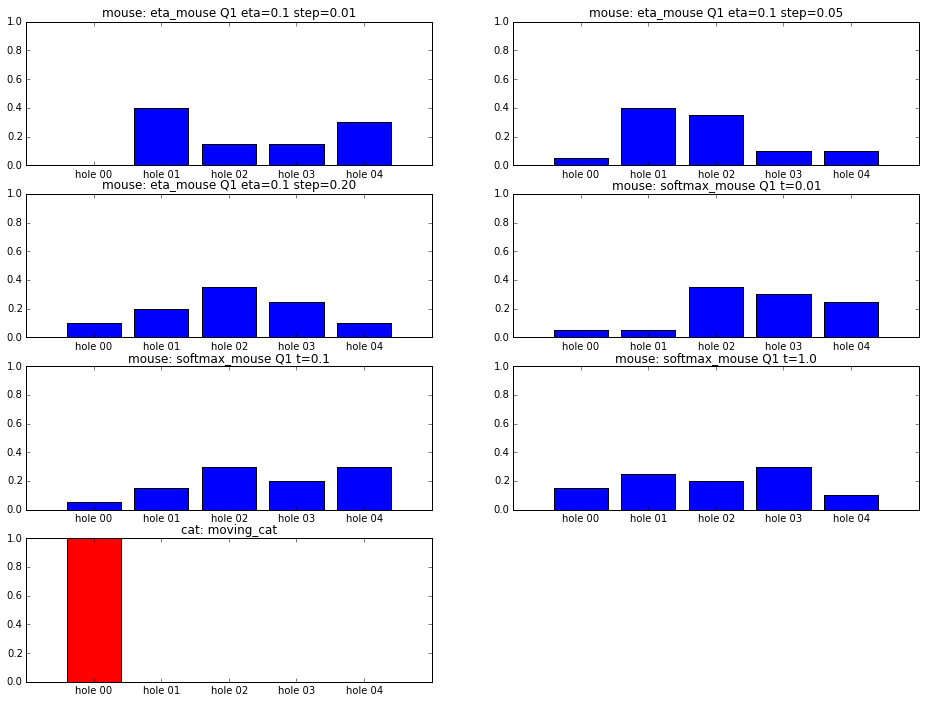

In [5]:
print('plotting changing distribution')

interact(get_cat_mouse_dists_interact_func(cat_dists, mouse_dists), round=(0,len(mouse_dists)-1,1));

# Saw distribution cat

In [6]:
mouse_dists, cat_dists = run_game(mice=[softmax_RL_mouse, softmax_RL_mouse2, softmax_RL_mouse3,
                                        eta_greedy_RL_mouse, eta_greedy_RL_mouse2, eta_greedy_RL_mouse3], 
                                  cats=[saw_distribution_cat], 
                                  num_holes=num_holes,
                                  total_rounds=200, iters_per_round=20, summary_last_n=50)

00020: agent: softmax_mouse Q1 t=0.01	score: 0.80/0.80	dist:[7, 0, 1, 12, 0]
00020: agent: softmax_mouse Q1 t=0.1	score: 0.60/0.60	dist:[3, 0, 0, 8, 9]
00020: agent: softmax_mouse Q1 t=1.0	score: 0.80/0.80	dist:[3, 8, 2, 4, 3]
00020: agent: eta_mouse Q1 eta=0.1 step=0.01	score: 0.80/0.80	dist:[0, 1, 0, 19, 0]
00020: agent: eta_mouse Q1 eta=0.1 step=0.05	score: 0.70/0.70	dist:[0, 0, 2, 18, 0]
00020: agent: eta_mouse Q1 eta=0.1 step=0.20	score: 0.70/0.70	dist:[0, 0, 1, 17, 2]
00020: agent: saw_cat	score: 0.75/0.75	dist:[0, 1, 8, 4, 7]
00040: agent: softmax_mouse Q1 t=0.01	score: 0.90/0.90	dist:[27, 0, 1, 12, 0]
00040: agent: softmax_mouse Q1 t=0.1	score: 0.72/0.72	dist:[14, 0, 0, 12, 14]
00040: agent: softmax_mouse Q1 t=1.0	score: 0.85/0.85	dist:[9, 14, 5, 7, 5]
00040: agent: eta_mouse Q1 eta=0.1 step=0.01	score: 0.72/0.72	dist:[0, 1, 2, 37, 0]
00040: agent: eta_mouse Q1 eta=0.1 step=0.05	score: 0.62/0.62	dist:[1, 0, 2, 36, 1]
00040: agent: eta_mouse Q1 eta=0.1 step=0.20	score: 0.62/0.62

ROUND #99


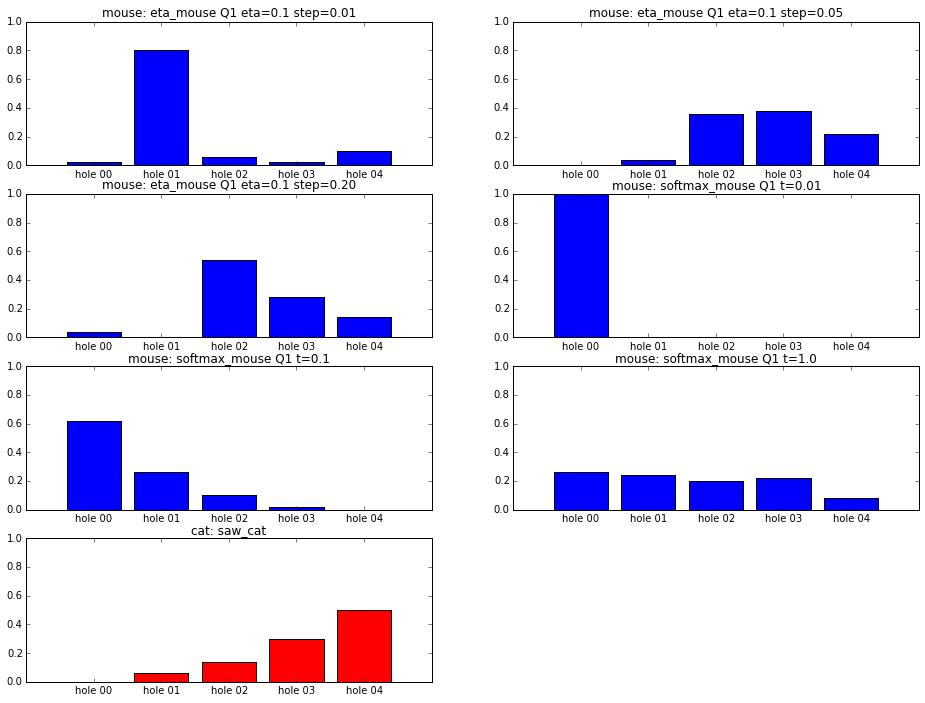

In [7]:
print('plotting saw distribution')

interact(get_cat_mouse_dists_interact_func(cat_dists, mouse_dists), round=(0,len(mouse_dists)-1,1));